In [1]:
import sys
sys.path.insert(1, '/home/jupyter-rdutt2/Raman Data/Utils')

In [19]:
#from utils import *
from general_utils import *
from pretraining_utils import *

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

from learningratefinder import LearningRateFinder

import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
BATCH_SIZE=128
lr=0.3
momentum=0.9
EPOCHS=50

In [4]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

    return focal_loss_fixed

def get_cosine_schedule_with_warmup(lr,num_warmup_steps, num_training_steps, num_cycles=0.75):
  
    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return (float(epoch) / float(max(1, num_warmup_steps))) * lr

        progress = float(epoch - num_warmup_steps ) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=0.00004,num_warmup_steps=4, num_training_steps=EPOCHS)

# HIV Dataset


In [5]:
#Directly loading since dataset has already been saved
x_train=np.load('../hiv/hiv_images_std_resized_train.npy')
x_val=np.load('../hiv/hiv_images_std_resized_val.npy')
x_train.shape, x_val.shape

((32757, 160, 160, 3), (4095, 160, 160, 3))

In [6]:
y_train = get_labels('hiv', 'train', 'std')
y_val = get_labels('hiv', 'valid', 'std')
num_classes = len(np.unique(y_train))
num_classes

../hiv/hiv-featurized/smiles2img/std/index/train_dir/
Labels length:  32757
../hiv/hiv-featurized/smiles2img/std/index/valid_dir/
Labels length:  4095


2

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((32757, 160, 160, 3), (32757, 1), (4095, 160, 160, 3), (4095, 1))

In [8]:
[np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1)]

[31705, 1052]

In [25]:
[np.count_nonzero(y_val == 0), np.count_nonzero(y_val == 1)]

[3972, 123]

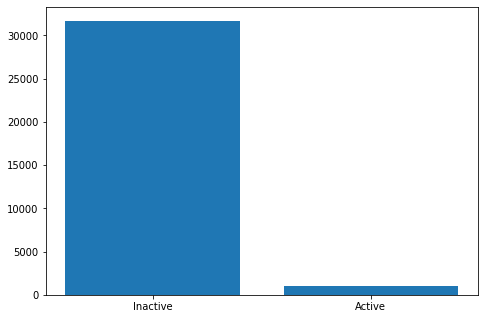

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Inactive', 'Active']
students = [np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1)]
ax.bar(langs,students)
plt.show()

In [10]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_train_cat.shape, y_val_cat.shape

((32757, 2), (4095, 2))

In [11]:
STEPS_PER_EPOCH=x_train.shape[0]//BATCH_SIZE
VAL_STEPS=x_val.shape[0]//BATCH_SIZE

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn = focal_loss()    #Focal Loss for imbalanced classification
aug = ImageDataGenerator() #ImageDataGenerator with no Augmentation.

# ResNet50x1

## Random Initialization

In [26]:
from architecture_utils import *

resnet=get_model(None, length=50, shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
model = tf.keras.Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=optimizer,
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=['accuracy'])

Using Noneweights


In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________


## In case of Random Weights, we find the optimal Learning Rate to start with.
### Finding LR

In [28]:
lrf = LearningRateFinder(model)

lrf.find(
aug.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
1e-7, 1e+1,
stepsPerEpoch=np.ceil((len(x_train) / float(BATCH_SIZE))),
epochs=7,
batchSize=BATCH_SIZE)

Epoch 1/7
256/256 [==============================] - 1274s 5s/step - loss: 0.0886 - accuracy: 0.9376
Epoch 2/7
256/256 [==============================] - 1277s 5s/step - loss: 0.0602 - accuracy: 0.9666
Epoch 3/7
256/256 [==============================] - 1285s 5s/step - loss: 0.0529 - accuracy: 0.9655
Epoch 4/7
256/256 [==============================] - 1286s 5s/step - loss: 0.0411 - accuracy: 0.9670
Epoch 5/7
256/256 [==============================] - 1286s 5s/step - loss: 0.0386 - accuracy: 0.9676
Epoch 6/7
256/256 [==============================] - 1288s 5s/step - loss: 0.2253 - accuracy: 0.9652


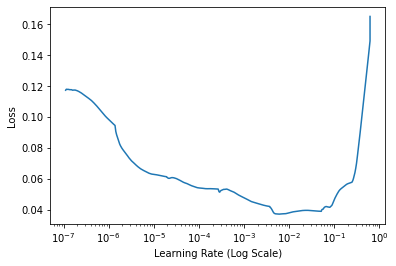

In [29]:
lrf.plot_loss()

In [30]:
LRFIND_PLOT_PATH = '../Plots/HIV/LRFinder/ResNet50_random_init_focal_loss.png'
plt.savefig(LRFIND_PLOT_PATH)

<Figure size 432x288 with 0 Axes>

### Model init with optimal LR

In [31]:
BATCH_SIZE=128
lr=3e-6
momentum=0.9
STEPS_PER_EPOCH=x_train.shape[0]//BATCH_SIZE
VAL_STEPS=x_val.shape[0]//BATCH_SIZE

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn = tfa.losses.SigmoidFocalCrossEntropy()
aug = ImageDataGenerator()

In [33]:
resnet=get_model(None, length=50, shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
model = tf.keras.Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

Using Noneweights


In [34]:
config_defaults = dict(
    batch_size=BATCH_SIZE,
    momentum=momentum,
    learn_rate=lr
    )
wandb.init(project="summer-2020", id="ResNet50_HIV_random_init_NO_AUG_FOCAL_LOSS", config=config_defaults) 
config = wandb.config

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [35]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
filepath='../Models/HIV/resnet50_random_focal_loss.h5'
mc = ModelCheckpoint(filepath=filepath , monitor='val_loss', save_weights_only=False, save_model=True, save_best_only=True)
wb = WandbCallback(monitor='val_loss', save_weights_only=False, save_model=True)
callbacks=[mc, wb]

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
history = model.fit(aug.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
          epochs=50,
          verbose=1,
          steps_per_epoch = STEPS_PER_EPOCH,
          validation_data=(x_val, y_val_cat),
          validation_steps=VAL_STEPS,
          callbacks=callbacks)

Epoch 1/50


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


255/255 [==============================] - 1307s 5s/step - loss: 0.0668 - accuracy: 0.9548 - val_loss: 0.0528 - val_accuracy: 0.9700
Epoch 2/50
255/255 [==============================] - 1279s 5s/step - loss: 0.0559 - accuracy: 0.9663 - val_loss: 0.0451 - val_accuracy: 0.9700
Epoch 3/50
255/255 [==============================] - 1272s 5s/step - loss: 0.0521 - accuracy: 0.9665 - val_loss: 0.0429 - val_accuracy: 0.9700
Epoch 4/50
255/255 [==============================] - 1274s 5s/step - loss: 0.0498 - accuracy: 0.9662 - val_loss: 0.0414 - val_accuracy: 0.9700
Epoch 5/50
255/255 [==============================] - 1269s 5s/step - loss: 0.0455 - accuracy: 0.9668 - val_loss: 0.0440 - val_accuracy: 0.9700
Epoch 6/50
255/255 [==============================] - 1268s 5s/step - loss: 0.0431 - accuracy: 0.9672 - val_loss: 0.0404 - val_accuracy: 0.9700
Epoch 7/50
255/255 [==============================] - 1266s 5s/step - loss: 0.0412 - accuracy: 0.9672 - val_loss: 0.0430 - val_accuracy: 0.9700
Epo

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

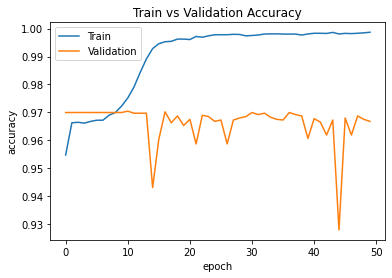

In [40]:
plot_acc(history, 'accuracy', 'val_accuracy', True)

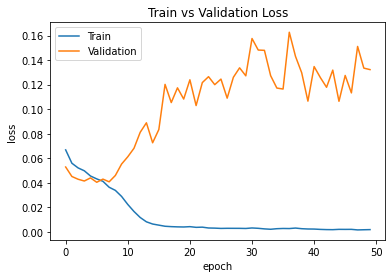

In [42]:
plot_loss(history, 'loss', 'val_loss', True)

# Imagenet Weights

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn = tfa.losses.SigmoidFocalCrossEntropy()
aug = ImageDataGenerator()

In [21]:
from architecture_utils import *

resnet=get_model('imagenet', length=50, shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
model = tf.keras.Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

Using imagenet weights


### Using Cosine LR because Fine-Tuning


In [22]:
BATCH_SIZE=128
#lr=1e-3
#momentum=0.9
STEPS_PER_EPOCH=x_train.shape[0]//BATCH_SIZE
VAL_STEPS=x_val.shape[0]//BATCH_SIZE

In [23]:
config_defaults = dict(
    batch_size=BATCH_SIZE,
    momentum=momentum,
    learn_rate=lr
    )
wandb.init(project="summer-2020", id="ResNet50_HIV_imagenet_init_2_NO_AUG_FOCAL_LOSS", config=config_defaults) 
config = wandb.config

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Streaming file created twice in same run: /home/jupyter-rdutt2/Raman Data/Pretraining Experiments/wandb/run-20200809_152706-ResNet50_HIV_imagenet_init_2_NO_AUG_FOCAL_LOSS/wandb-history.jsonl
Streaming file created twice in same run: /home/jupyter-rdutt2/Raman Data/Pretraining Experiments/wandb/run-20200809_152706-ResNet50_HIV_imagenet_init_2_NO_AUG_FOCAL_LOSS/wandb-events.jsonl


In [24]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])
filepath='../Models/HIV/resnet50_imagenet_FOCAL_LOSS.h5'
mc = ModelCheckpoint(filepath=filepath , monitor='val_loss', save_weights_only=False, save_model=True, save_best_only=True)

wb = WandbCallback(monitor='val_loss', save_weights_only=False, save_model=True)
callbacks=[mc, wb, lr_schedule]

In [ ]:
history = model.fit(aug.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
          epochs=50,
          verbose=1,
          steps_per_epoch = STEPS_PER_EPOCH,
          validation_data=(x_val, y_val_cat),
          validation_steps=VAL_STEPS,
          callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/50


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


255/255 [==============================] - 1332s 5s/step - loss: 0.3071 - accuracy: 0.5223 - val_loss: 0.0712 - val_accuracy: 0.9700 - lr: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 2/50
255/255 [==============================] - 1325s 5s/step - loss: 0.0578 - accuracy: 0.9568 - val_loss: 0.0461 - val_accuracy: 0.9700 - lr: 1.0000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 3/50
255/255 [==============================] - 1326s 5s/step - loss: 0.0387 - accuracy: 0.9679 - val_loss: 0.0441 - val_accuracy: 0.9687 - lr: 2.0000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
Epoch 4/50
255/255 [==============================] - 1316s 5s/step - loss: 0.0299 - accuracy: 0.9686 - val_loss: 0.0454 - val_accuracy: 0.9658 - lr: 3.0000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 5/50
255/255 [==============================] - 1321s 5s/step - loss

In [ ]:
plot_acc(history, 'accuracy', 'val_accuracy', True)

In [ ]:
plot_acc(history, 'loss', 'val_loss', True)